In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanMetric, AUROC
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch import Tensor
from torch import nn
from tqdm import tqdm

In [228]:
train_df = pd.read_csv("/kaggle/input/dl-dz1/loan_train.csv").drop(columns=["id"])
test_df = pd.read_csv("/kaggle/input/dl-dz1/loan_test.csv").drop(columns=["id"])

cat_features = train_df.drop(columns=["loan_status"]).select_dtypes("object").columns
num_features = train_df.drop(columns=["loan_status"]).select_dtypes("number").columns

CAT_MAPS = {
    cat_col: 
        {value: encoded_value 
            for encoded_value, value in enumerate(train_df[cat_col].unique())} 
        for cat_col in cat_features
}

In [232]:
CAT_MAPS


{'person_home_ownership': {'MORTGAGE': 0, 'RENT': 1, 'OWN': 2, 'OTHER': 3},
 'loan_intent': {'EDUCATION': 0,
  'HOMEIMPROVEMENT': 1,
  'MEDICAL': 2,
  'DEBTCONSOLIDATION': 3,
  'VENTURE': 4,
  'PERSONAL': 5},
 'loan_grade': {'A': 0, 'D': 1, 'B': 2, 'C': 3, 'F': 4, 'E': 5, 'G': 6},
 'cb_person_default_on_file': {'N': 0, 'Y': 1}}

In [3]:
class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
class LoanDataset(Dataset):
    def __init__(self, data: pd.DataFrame, target: pd.DataFrame):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        target_item = self.target.iloc[idx]

        out = {"num_features": {}, "cat_features": {}}

        for col in item.index.to_list():
            if col in cat_features:
                out["cat_features"][col] = torch.scalar_tensor(CAT_MAPS[col][item[col]], dtype=torch.long)
            else:
                out["num_features"][col] = torch.scalar_tensor(item[col], dtype=torch.float)

        out["target"] = torch.scalar_tensor(target_item, dtype=torch.float)
        
        return out

In [5]:
class LoanCollator:
    def __call__(self, items):
        out = {"num_features": {}, "cat_features": {}}

        if "target" in items[0]:
            out["target"] = torch.stack([x["target"] for x in items])

        for key in items[0]["cat_features"].keys():
            out["cat_features"][key] = torch.stack([x["cat_features"][key] for x in items])

        for key in items[0]["num_features"].keys():
            out["num_features"][key] = torch.stack([x["num_features"][key] for x in items])

        return out

In [6]:
train_df.drop(columns=["loan_status", *cat_features])

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,21,102000,5.0,10000,7.51,0.10,4
1,23,49000,1.0,5000,13.17,0.10,4
2,23,30000,1.0,10000,11.99,0.33,4
3,32,95000,9.0,15000,12.84,0.16,5
4,31,32000,3.0,1200,7.68,0.04,10
...,...,...,...,...,...,...,...
52775,21,24000,5.0,5000,14.72,0.21,2
52776,31,42500,15.0,8000,16.29,0.19,6
52777,31,65000,2.0,10000,11.36,0.15,9
52778,49,120000,11.0,12000,12.69,0.10,15


In [7]:
num_features

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')

In [8]:
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(train_df.drop(columns=["loan_status", *cat_features], axis=1)), columns=num_features)
Test_scaled = pd.DataFrame(scaler.transform(test_df.drop(columns=["loan_status", *cat_features], axis=1)), columns=num_features)

X_scaled = pd.concat([X_scaled, train_df[cat_features]], axis=1)
Test_scaled = pd.concat([Test_scaled, test_df[cat_features]], axis=1)

x_train, x_val, y_train, y_val = train_test_split(X_scaled, train_df["loan_status"], test_size=0.2, stratify=train_df["loan_status"])

train_dataset = LoanDataset(x_train, y_train)
val_dataset = LoanDataset(x_val, y_val)
test_dataset = LoanDataset(Test_scaled, test_df["loan_status"])

In [101]:
def train(model: nn.Module, train_dataset: Dataset, eval_dataset: Dataset, config : dict):
    
    seed = 52
    device = "cuda" if torch.cuda.is_available() else "cpu"
    n_epochs = config["num_epochs"]
    lr = config["lr"]
    weight_decay = config["decay"] if "decay" in config else 0.0
    batch_size = config["batch_size"]
    
    torch.random.manual_seed(seed)

    model = model.to(device)
    loss_bce = torch.nn.BCEWithLogitsLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_dl = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
    eval_dl = DataLoader(eval_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
    
    history = {"train_losses": [], "train_auc": [], "val_losses": [], "val_auc": []}
    best_eval_loss = float('inf')
    
    for i_epoch in tqdm(range(n_epochs)):
        train_loss = MeanMetric().to(device)
        train_rocauc = AUROC(task='binary').to(device)
        for i, batch in enumerate(train_dl):
            # data, target = batch[0].to(device), batch[1].to(device)
            # result = model(data)

            ##
            num_features, cat_features, target = batch["num_features"], batch["cat_features"], batch["target"].to(device)

            for col in num_features:
                num_features[col] = num_features[col].to(device)
                
            for col in cat_features:
                cat_features[col] = cat_features[col].to(device)
                
            result = model(num_features=num_features, cat_features=cat_features)

            ##
            
            loss_value = loss_bce(result, target)
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss_value)
            train_rocauc.update(torch.sigmoid(result), target)

        train_loss = train_loss.compute().item()
        train_rocauc = train_rocauc.compute().item()

        history["train_losses"].append(train_loss)
        history["train_auc"].append(train_rocauc)
        
        eval_loss = MeanMetric().to(device)
        eval_rocauc = AUROC(task='binary').to(device)

        
        model.eval()
        with torch.no_grad():
            for i_eval, batch_eval in enumerate(eval_dl):
                # data, target = batch_eval[0].to(device), batch_eval[1].to(device)

                # result_eval = model(data)
                
                ##
                num_features, cat_features, target = batch_eval["num_features"], batch_eval["cat_features"], batch_eval["target"].to(device)

                for col in num_features:
                    num_features[col] = num_features[col].to(device)
                    
                for col in cat_features:
                    cat_features[col] = cat_features[col].to(device)
                    
                result_eval = model(num_features=num_features, cat_features=cat_features)

                ##
                
                eval_loss_value = loss_bce(result_eval, target)

                eval_loss.update(eval_loss_value)
                eval_rocauc.update(torch.sigmoid(result_eval),target)
        model.train()

        eval_loss = eval_loss.compute().item()
        eval_rocauc = eval_rocauc.compute().item()
        
        history["val_losses"].append(eval_loss)
        history["val_auc"].append(eval_rocauc)

        if eval_loss < best_eval_loss:
            torch.save(model.state_dict(), "/kaggle/working/model.pt")
            
    return history

In [100]:
def test(model: nn.Module, test_dataset: Dataset, config: dict):
    model.eval()
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)

    test_dl = DataLoader(test_dataset, batch_size=config["batch_size"])
    
    loss_bce = torch.nn.BCEWithLogitsLoss()
    test_loss = MeanMetric().to(device)
    test_rocauc = AUROC(task='binary').to(device)
    
    model.eval()
    with torch.no_grad():
        for i_eval, batch in enumerate(test_dl):
            # data, target = batch[0].to(device), batch[1].to(device)

            # result_eval = model(data)

            ##
            num_features, cat_features, target = batch["num_features"], batch["cat_features"], batch["target"].to(device)

            for col in num_features:
                num_features[col] = num_features[col].to(device)
                
            for col in cat_features:
                cat_features[col] = cat_features[col].to(device)
                
            result_eval = model(num_features=num_features, cat_features=cat_features)

            ##
            
            loss_value = loss_bce(result_eval, target)

            test_loss.update(loss_value)
            test_rocauc.update(torch.sigmoid(result_eval),target)

    test_loss = test_loss.compute().item()
    test_rocauc = test_rocauc.compute().item()
        
    return test_loss, test_rocauc

In [11]:
class SimpleLoanModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        self.linear_in = nn.Linear(input_size, hidden_size)
        
        self.linear1 = nn.Linear(hidden_size, hidden_size * 4)
        self.linear2 = nn.Linear(hidden_size * 4, hidden_size)
        
        self.linear_out = nn.Linear(hidden_size, 1)
        
        self.relu = nn.ReLU()

        
    def forward(self, x: Tensor):
        x = self.linear_in(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear_out(x)
        return x.squeeze(-1)

In [12]:
CAT_MAPS

{'person_home_ownership': {'MORTGAGE': 0, 'RENT': 1, 'OWN': 2, 'OTHER': 3},
 'loan_intent': {'EDUCATION': 0,
  'HOMEIMPROVEMENT': 1,
  'MEDICAL': 2,
  'DEBTCONSOLIDATION': 3,
  'VENTURE': 4,
  'PERSONAL': 5},
 'loan_grade': {'A': 0, 'D': 1, 'B': 2, 'C': 3, 'F': 4, 'E': 5, 'G': 6},
 'cb_person_default_on_file': {'N': 0, 'Y': 1}}

Experiment 1
------------

In [134]:
class SimpleLoanModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.emb1 = nn.Embedding(4, hidden_size//8)
        self.emb2 = nn.Embedding(6, hidden_size//8)
        self.emb3 = nn.Embedding(7, hidden_size//8)
        self.emb4 = nn.Embedding(2, hidden_size//8)
        
        self.linear_in = nn.Linear(7, hidden_size//2)
        
        self.linear1 = nn.Linear(hidden_size, hidden_size * 4)
        self.linear2 = nn.Linear(hidden_size * 4, hidden_size)
        
        self.linear_out = nn.Linear(hidden_size, 1)
        
        self.relu = nn.ReLU()

        
    def forward(self, num_features: Tensor, cat_features: Tensor):
        x_1 = self.emb1(cat_features["person_home_ownership"])
        x_2 = self.emb2(cat_features["loan_intent"])
        x_3 = self.emb3(cat_features["loan_grade"])
        x_4 = self.emb4(cat_features["cb_person_default_on_file"])
        
        
        x_num = self.linear_in(torch.stack([feature for feature in num_features.values()], dim=-1))

        x = torch.cat([x_1, x_2, x_3, x_4, x_num], axis=-1)
        
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.linear_out(x)
        return x.squeeze(-1)

In [135]:
config = {
    "num_epochs": 30,
    "lr": 0.01,
    "hidden_size": 32,
    "batch_size": 32
}

model = SimpleLoanModel(config["hidden_size"])

history = train(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    config=config,
)

100%|██████████| 30/30 [04:22<00:00,  8.75s/it]


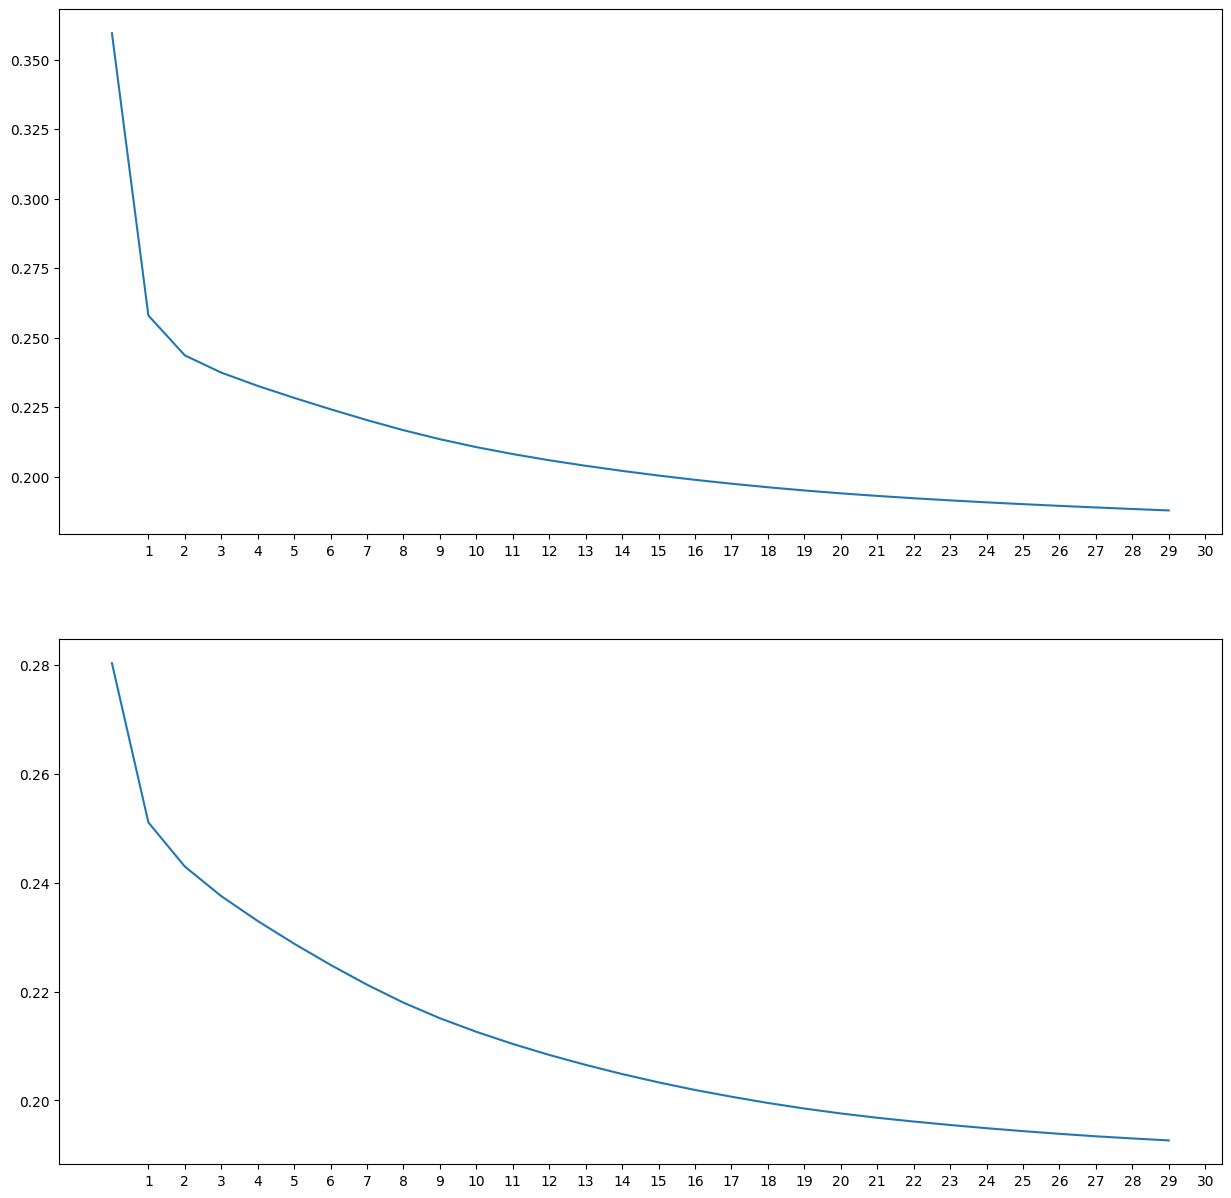

In [136]:
figure, axis = plt.subplots(2, 1, figsize=(15, 15))
axis[0].plot(history["train_losses"])
axis[0].set_xticks(range(1, len(history["train_losses"])+1))

axis[1].plot(history["val_losses"])
axis[1].set_xticks(range(1, len(history["val_losses"])+1))

plt.show()

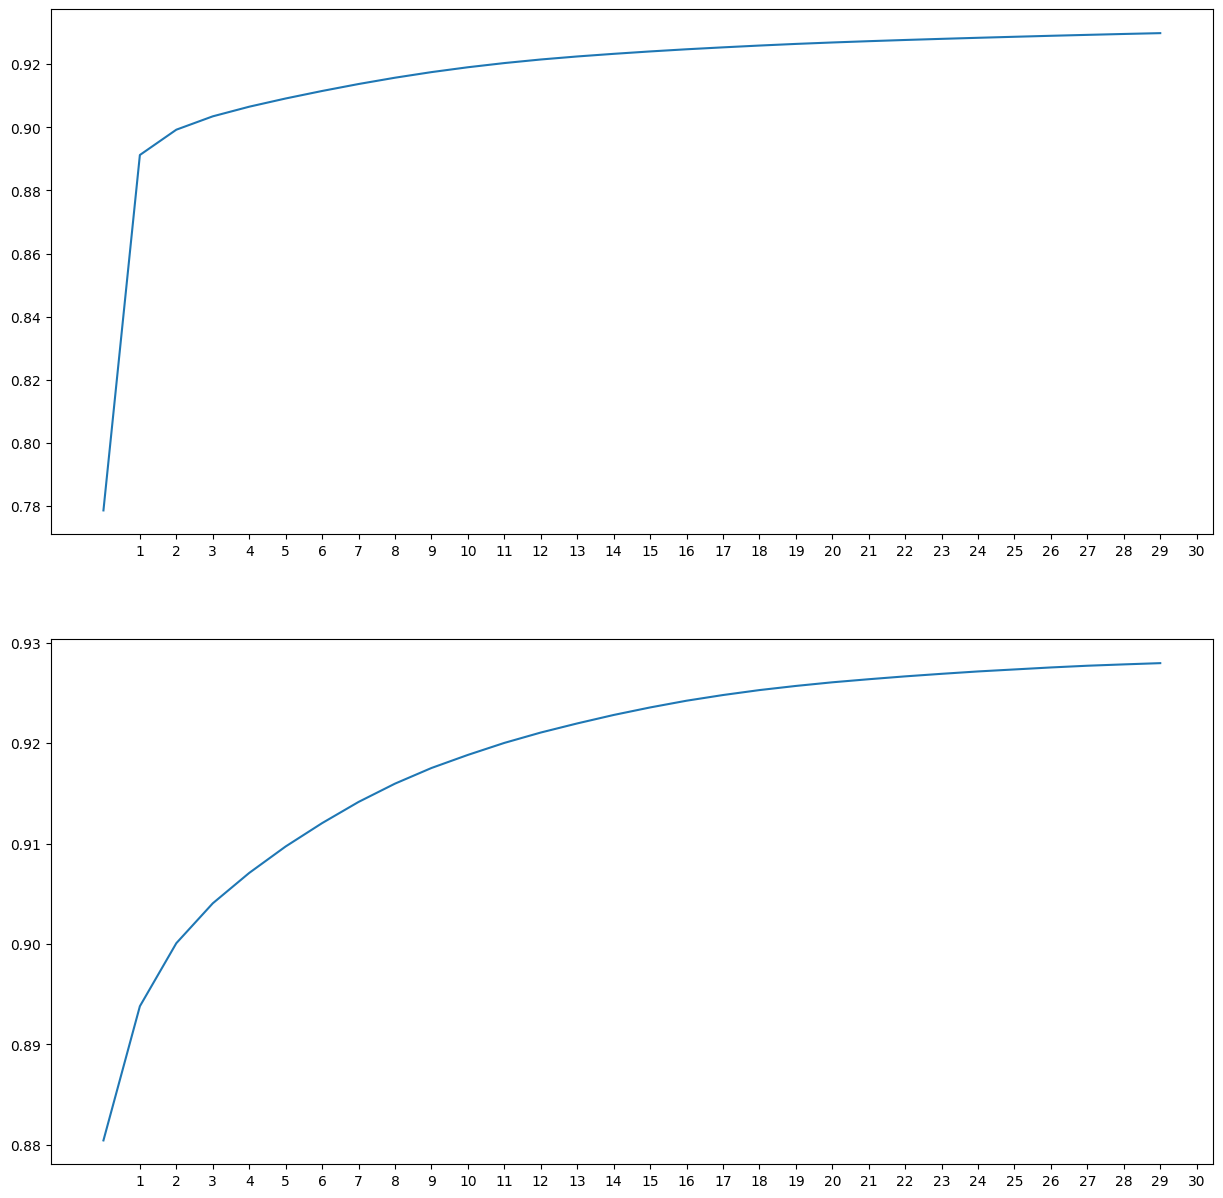

In [137]:
figure, axis = plt.subplots(2, 1, figsize=(15, 15))
axis[0].plot(history["train_auc"])
axis[0].set_xticks(range(1, len(history["train_auc"])+1))

axis[1].plot(history["val_auc"])
axis[1].set_xticks(range(1, len(history["val_auc"])+1))

plt.show()

In [138]:
min_value = float("inf")
epoch = -1

min_val_loss = min(history["val_losses"])

if min_val_loss < min_value:
    min_value = min_val_loss
    epoch = history["val_losses"].index(min_val_loss)

min_value, epoch

(0.19265513122081757, 29)

In [139]:
model.load_state_dict(torch.load("/kaggle/working/model.pt"))

<ipython-input-139-2dc0f79c5215>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/model.pt"))


<All keys matched successfully>

In [140]:
loss, auc = test(
    model=model,
    test_dataset=test_dataset,
    config=config)

loss, auc

(0.1856980323791504, 0.9320043921470642)

Experiment 2
------------


In [143]:
class LoanModelBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear1 = nn.Linear(hidden_size, hidden_size*4)
        self.linear2 = nn.Linear(hidden_size*4, hidden_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)

        return x

class LoanModelExtra(nn.Module):
    def __init__(self, hidden_size: int, num_blocks: int = 1):
        super().__init__()
        self.emb1 = nn.Embedding(4, hidden_size//8)
        self.emb2 = nn.Embedding(6, hidden_size//8)
        self.emb3 = nn.Embedding(7, hidden_size//8)
        self.emb4 = nn.Embedding(2, hidden_size//8)
        
        self.numeric_linear = nn.Linear(7, hidden_size//2)

        self.linear_blocks = nn.Sequential(*[LoanModelBlock(hidden_size) for _ in range(num_blocks)])
        
        self.linear_out = nn.Linear(hidden_size, 1)

    def forward(self, num_features: Tensor, cat_features: Tensor):
        x_1 = self.emb1(cat_features["person_home_ownership"])
        x_2 = self.emb2(cat_features["loan_intent"])
        x_3 = self.emb3(cat_features["loan_grade"])
        x_4 = self.emb4(cat_features["cb_person_default_on_file"])
        
        
        x_num = self.numeric_linear(torch.stack([feature for feature in num_features.values()], dim=-1))

        x = torch.cat([x_1, x_2, x_3, x_4, x_num], axis=-1)
        

        for block in self.linear_blocks:
            x = block(x)

        result = self.linear_out(x)
        
        return result.squeeze(-1)

In [146]:
config = {
    "num_epochs": 30,
    "lr": 0.01,
    "hidden_size": 128,
    "batch_size": 64,
    "num_blocks": 3
}

model = LoanModelExtra(config["hidden_size"], config["num_blocks"])

history = train(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    config=config,
)

  0%|          | 0/30 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 240, in _feed
    writer_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
100%|██████████| 30/30 [04:31<00:00,  9.06s/it]


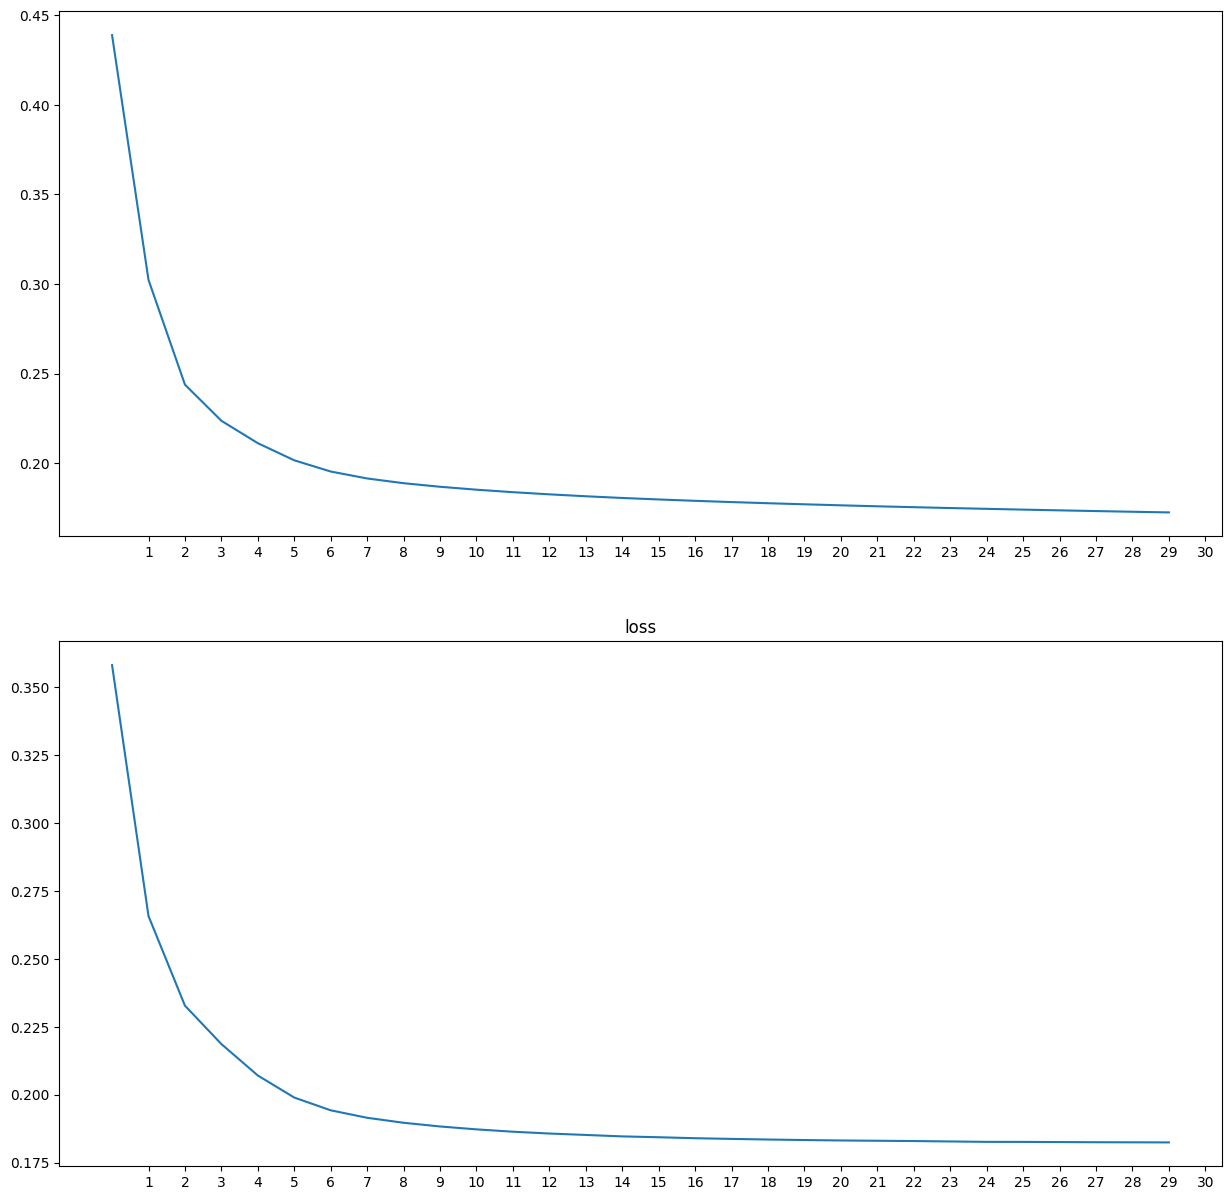

In [147]:
figure, axis = plt.subplots(2, 1, figsize=(15, 15))
axis[0].plot(history["train_losses"])
axis[0].set_xticks(range(1, len(history["train_losses"])+1))

axis[1].plot(history["val_losses"])
axis[1].set_xticks(range(1, len(history["val_losses"])+1))

plt.title("loss")
plt.show()

In [148]:
min_value = float("inf")
epoch = -1

min_val_loss = min(history["val_losses"])

if min_val_loss < min_value:
    min_value = min_val_loss
    epoch = history["val_losses"].index(min_val_loss)

min_value, epoch

(0.18246431648731232, 29)

In [149]:
model.load_state_dict(torch.load("/kaggle/working/model.pt"))

<ipython-input-149-2dc0f79c5215>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/model.pt"))


<All keys matched successfully>

In [150]:
loss, auc = test(
    model=model,
    test_dataset=test_dataset,
    config=config)

loss, auc

(0.17514561116695404, 0.9331996440887451)

Experiment 3
------------

In [216]:
import torch
from torch import nn, Tensor

class LoanModelBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear1 = nn.Linear(hidden_size, hidden_size*4)
        self.linear2 = nn.Linear(hidden_size*4, hidden_size)

        
        self.bn = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        to_skip = x
        x = self.bn(x)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)

        return x + to_skip

class LoanModelExtraWithBn(nn.Module):
    def __init__(self, hidden_size: int, num_blocks: int = 1):
        super().__init__()
        self.emb1 = nn.Embedding(4, hidden_size//8)
        self.emb2 = nn.Embedding(6, hidden_size//8)
        self.emb3 = nn.Embedding(7, hidden_size//8)
        self.emb4 = nn.Embedding(2, hidden_size//8)
        
        self.numeric_linear = nn.Linear(7, hidden_size//2)

        layers = []

        for _ in range(num_blocks):
            layers.append(LoanModelBlock(hidden_size))
            
        self.linear_blocks = nn.Sequential(*layers)
        
        self.linear_out = nn.Linear(hidden_size, 1)

    def forward(self, num_features: Tensor, cat_features: Tensor) -> Tensor:
        x_1 = self.emb1(cat_features["person_home_ownership"])
        x_2 = self.emb2(cat_features["loan_intent"])
        x_3 = self.emb3(cat_features["loan_grade"])
        x_4 = self.emb4(cat_features["cb_person_default_on_file"])
        
        
        x_num = self.numeric_linear(torch.stack([feature for feature in num_features.values()], dim=-1))

        x = torch.cat([x_1, x_2, x_3, x_4, x_num], axis=-1)
        

        x = self.linear_blocks(x)

        result = self.linear_out(x)

        return result.view(-1)

In [217]:
config = {
    "num_epochs": 30,
    "lr": 0.01,
    "hidden_size": 128,
    "batch_size": 128,
    "num_blocks": 3
}

model = LoanModelExtraWithBn(config["hidden_size"], config["num_blocks"])

In [218]:
history = train(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    config=config,
)

100%|██████████| 30/30 [03:16<00:00,  6.55s/it]


In [219]:
min_value = float("inf")
epoch = -1

min_val_loss = min(history["val_losses"])

if min_val_loss < min_value:
    min_value = min_val_loss
    epoch = history["val_losses"].index(min_val_loss)

min_value, epoch

(0.18813225626945496, 18)

In [220]:
model.load_state_dict(torch.load("/kaggle/working/model.pt"))

loss, auc = test(
    model=model,
    test_dataset=test_dataset,
    config=config)

loss, auc

<ipython-input-220-66a71e1a9d6c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/model.pt"))


(0.19776752591133118, 0.9238104224205017)

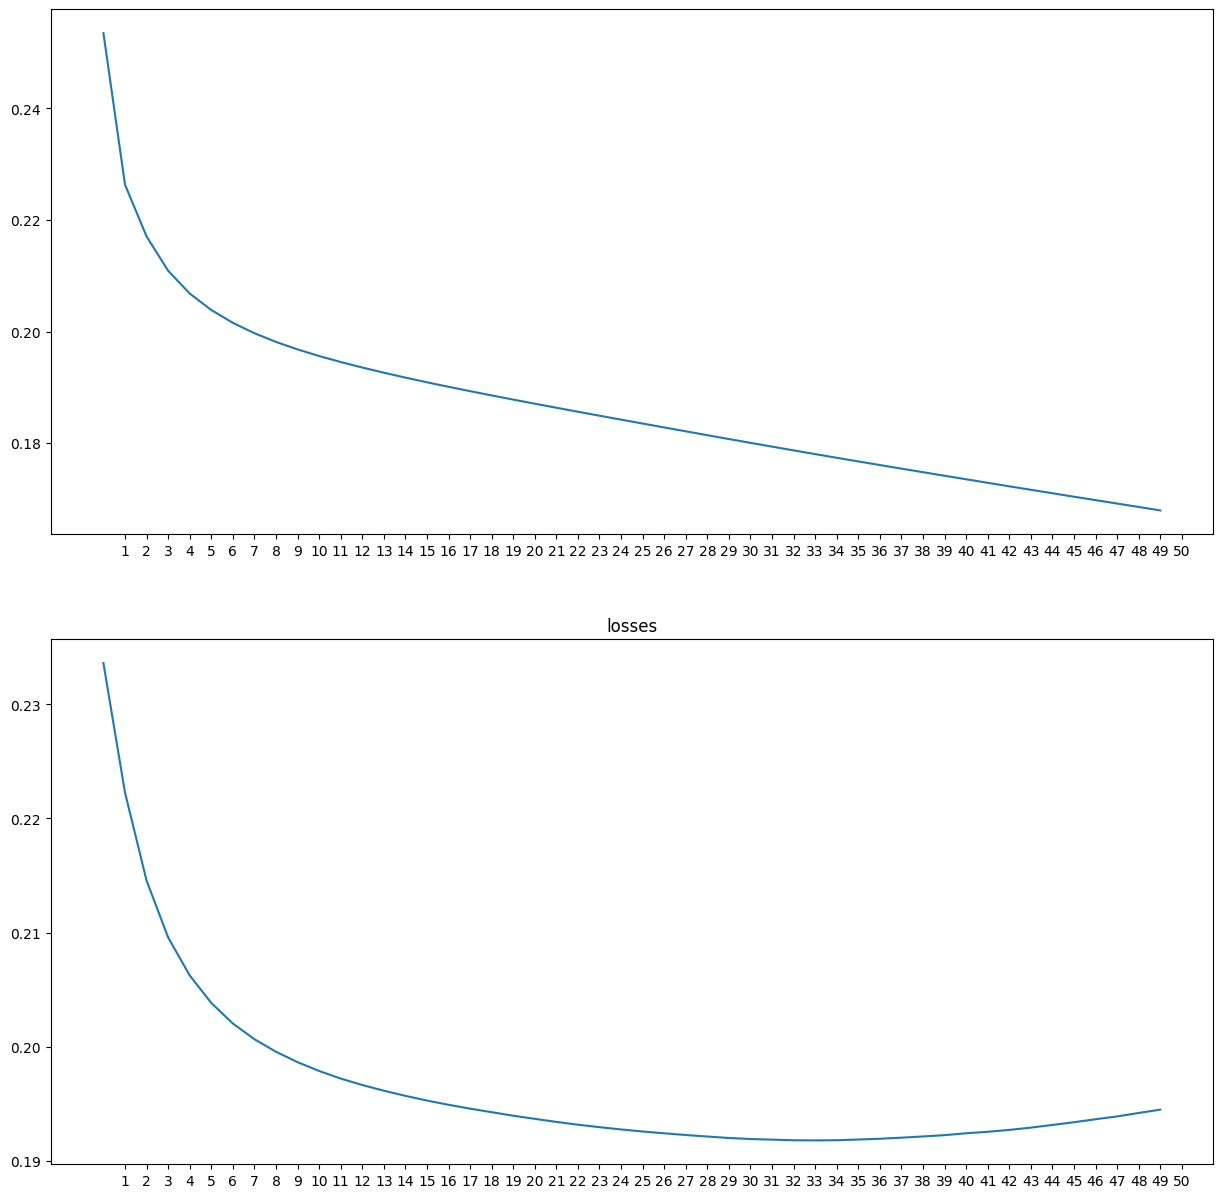

In [108]:
figure, axis = plt.subplots(2, 1, figsize=(15, 15))
axis[0].plot(history["train_losses"])
axis[0].set_xticks(range(1, len(history["train_losses"])+1))

axis[1].plot(history["val_losses"])
axis[1].set_xticks(range(1, len(history["val_losses"])+1))

plt.title("losses")
plt.show()

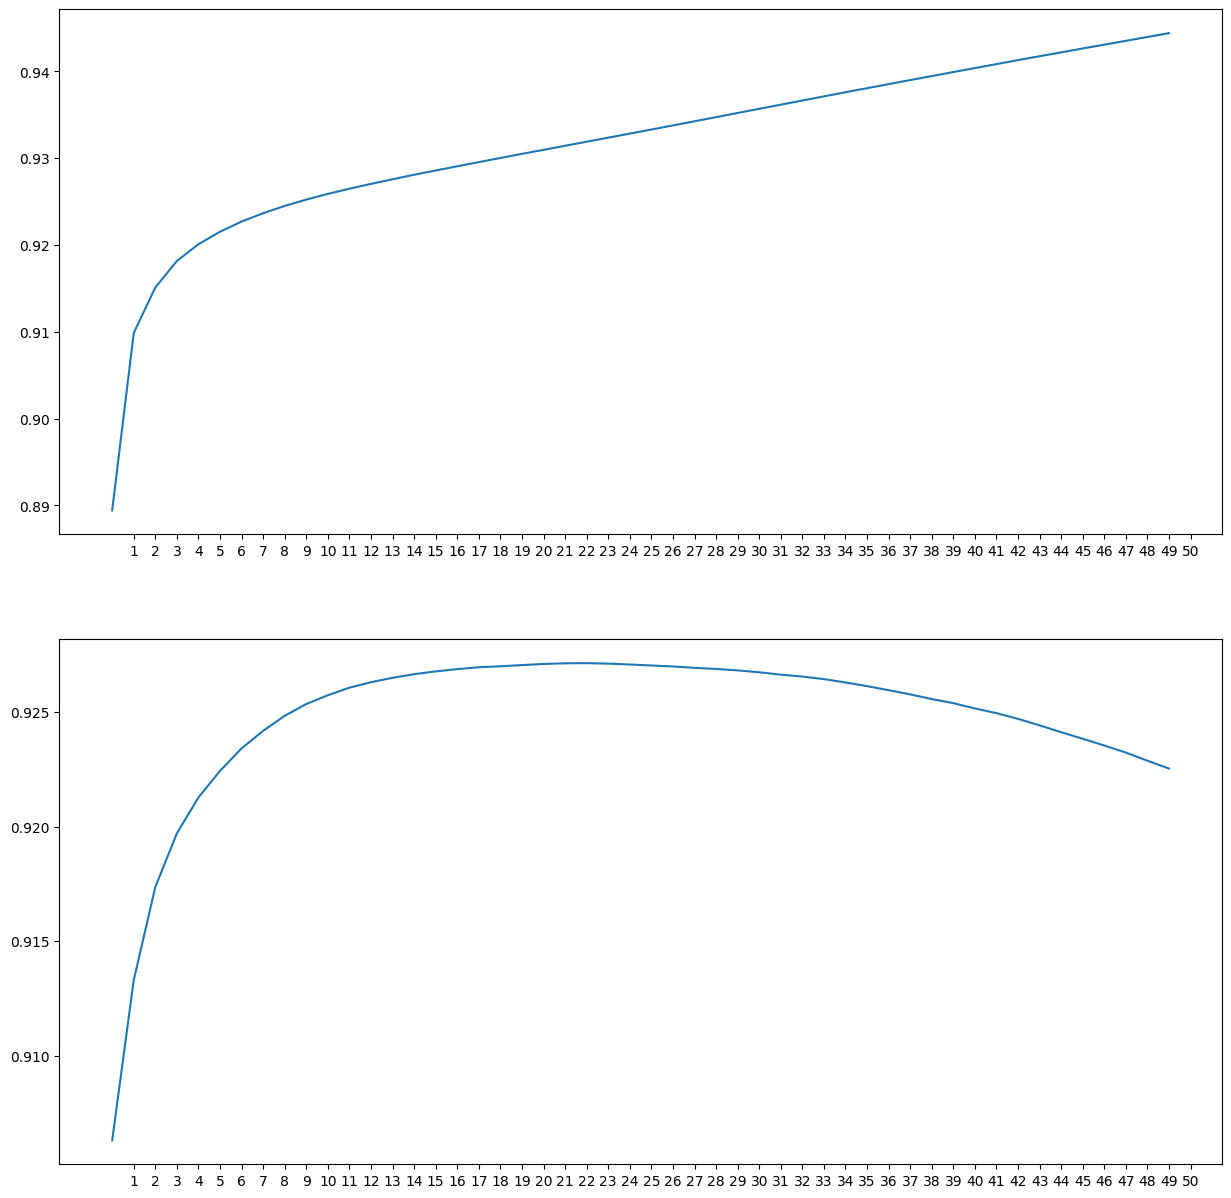

In [109]:
figure, axis = plt.subplots(2, 1, figsize=(15, 15))
axis[0].plot(history["train_auc"])
axis[0].set_xticks(range(1, len(history["train_auc"])+1))

axis[1].plot(history["val_auc"])
axis[1].set_xticks(range(1, len(history["train_auc"])+1))

plt.show("roc-auc")
plt.show()

Experiment 4
------------

In [223]:
import torch
from torch import nn, Tensor

class LoanModelBlock(nn.Module):
    def __init__(self, hidden_size, p):
        super().__init__()
        self.linear1 = nn.Linear(hidden_size, hidden_size*4)
        self.linear2 = nn.Linear(hidden_size*4, hidden_size)

        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=p)
    
    def forward(self, x):
        to_skip = x
        x = self.bn(x)
        x = self.relu(self.linear1(x))
        x = self.dropout(self.relu(self.linear2(x)))

        return x + to_skip
        
class LoanModelExtraWithDropout(nn.Module):
    def __init__(self, hidden_size: int, num_blocks: int = 1, p: int = 0.5):
        super().__init__()
        self.emb1 = nn.Embedding(4, hidden_size)
        self.emb2 = nn.Embedding(6, hidden_size)
        self.emb3 = nn.Embedding(7, hidden_size)
        self.emb4 = nn.Embedding(2, hidden_size)
        
        self.numeric_linear = nn.Linear(7, hidden_size)
        
        layers = []

        for _ in range(num_blocks):
            layers.append(LoanModelBlock(hidden_size, p))
            
        self.linear_blocks = nn.Sequential(*layers)
        
        self.linear_out = nn.Linear(hidden_size, 1)

    def forward(self, num_features: Tensor, cat_features: Tensor) -> Tensor:
        x_1 = self.emb1(cat_features["person_home_ownership"])
        x_2 = self.emb2(cat_features["loan_intent"])
        x_3 = self.emb3(cat_features["loan_grade"])
        x_4 = self.emb4(cat_features["cb_person_default_on_file"])
        
        
        x_num = self.numeric_linear(torch.stack([feature for feature in num_features.values()], dim=-1))

        x = x_1 + x_2 + x_3 + x_4 + x_num
                
        x = self.linear_blocks(x)
            
        result = self.linear_out(x)
        
        return result.view(-1)

In [221]:
configs = []
ps = [0.01, 0.1, 0.2, 0.5, 0.9] 
for p in ps:
    configs.append({
        "num_epochs": 30,
        "lr": 0.01,
        "hidden_size": 128,
        "batch_size": 128,
        "num_blocks": 3,
        "p": p
    })

In [224]:
history = []
metrics = []

for config in configs:
    model = LoanModelExtraWithDropout(config["hidden_size"], config["num_blocks"], config["p"])
    
    history_tmp = train(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    config=config,
    )
    history.append(history_tmp)
    
    model.load_state_dict(torch.load("/kaggle/working/model.pt"))

    test_loss, test_auc = test(
        model=model,
        test_dataset=test_dataset,
        config=config)

    metrics.append((test_loss, test_auc))

100%|██████████| 30/30 [03:22<00:00,  6.76s/it]
<ipython-input-224-4df5892827a8>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/

In [225]:
min_value = float("inf")
p = -1
epoch = -1
idx = - 1

for i, losses in enumerate(history):
    min_val_loss = min(losses["val_losses"])
    print(min_val_loss, ps[i], metrics[i])
    if min_val_loss < min_value:
        min_value = min_val_loss
        p = ps[i]
        epoch = losses["val_losses"].index(min_val_loss)
        idx = i
        
min_value, p, epoch

0.19094666838645935 0.01 (0.18383623659610748, 0.932042121887207)
0.19016318023204803 0.1 (0.1836288422346115, 0.9322414994239807)
0.19032424688339233 0.2 (0.18370670080184937, 0.9323510527610779)
0.19142180681228638 0.5 (0.18435022234916687, 0.932432234287262)
0.2021937072277069 0.9 (0.1927390992641449, 0.9295598268508911)


(0.19016318023204803, 0.1, 29)

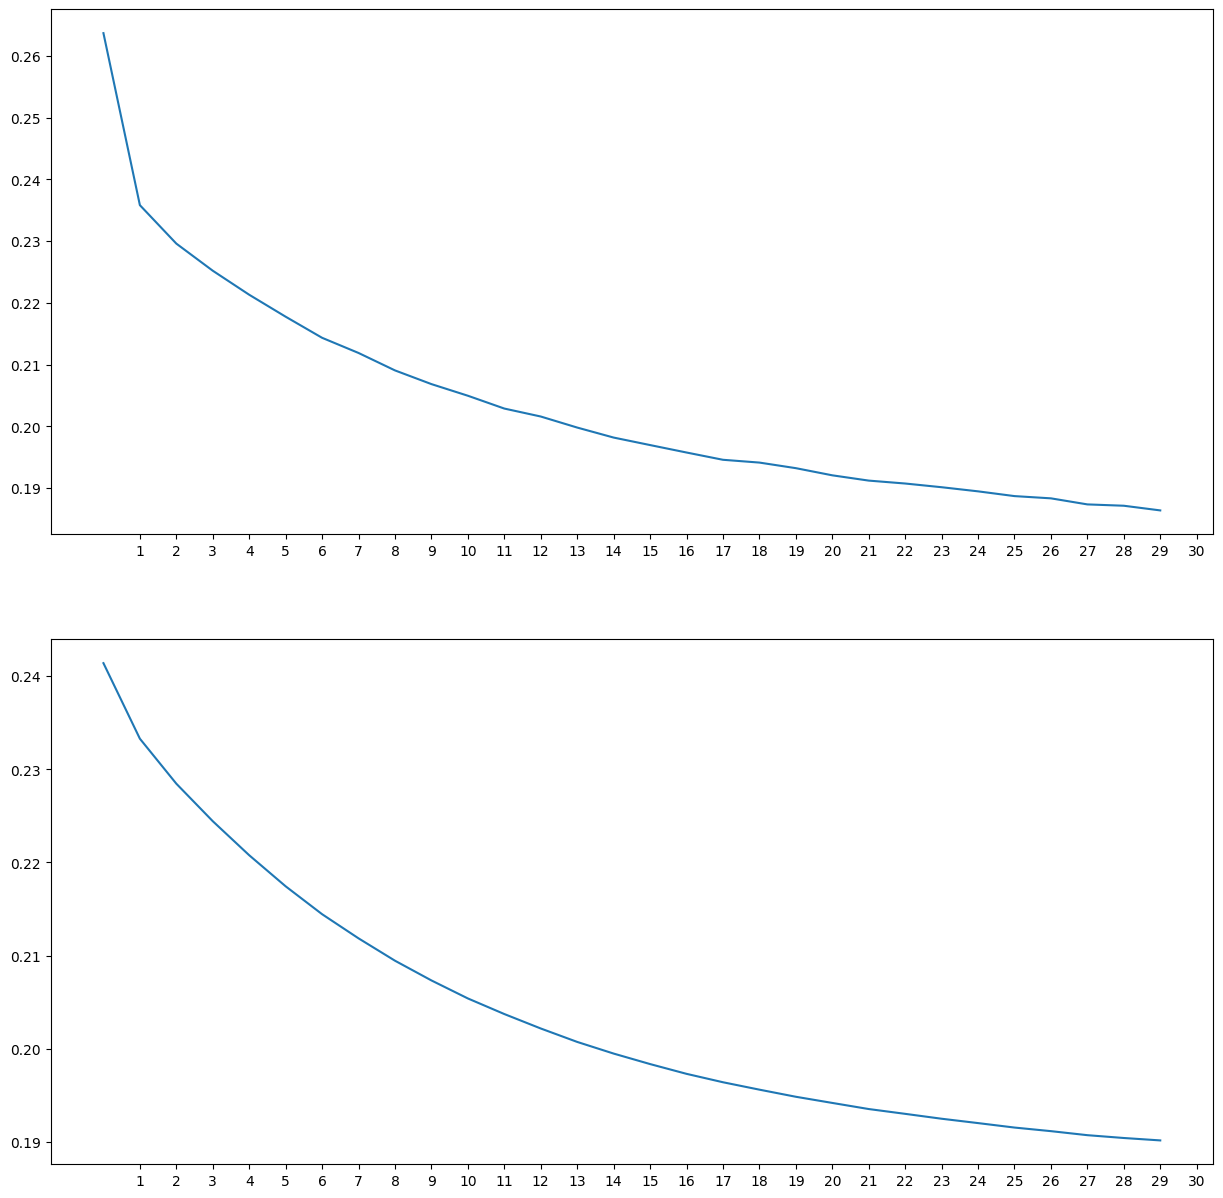

In [226]:
figure, axis = plt.subplots(2, 1, figsize=(15, 15))
axis[0].plot(history[idx]["train_losses"])
axis[0].set_xticks(range(1, len(history[idx]["train_losses"])+1))

axis[1].plot(history[idx]["val_losses"])
axis[1].set_xticks(range(1, len(history[idx]["val_losses"])+1))

plt.show()

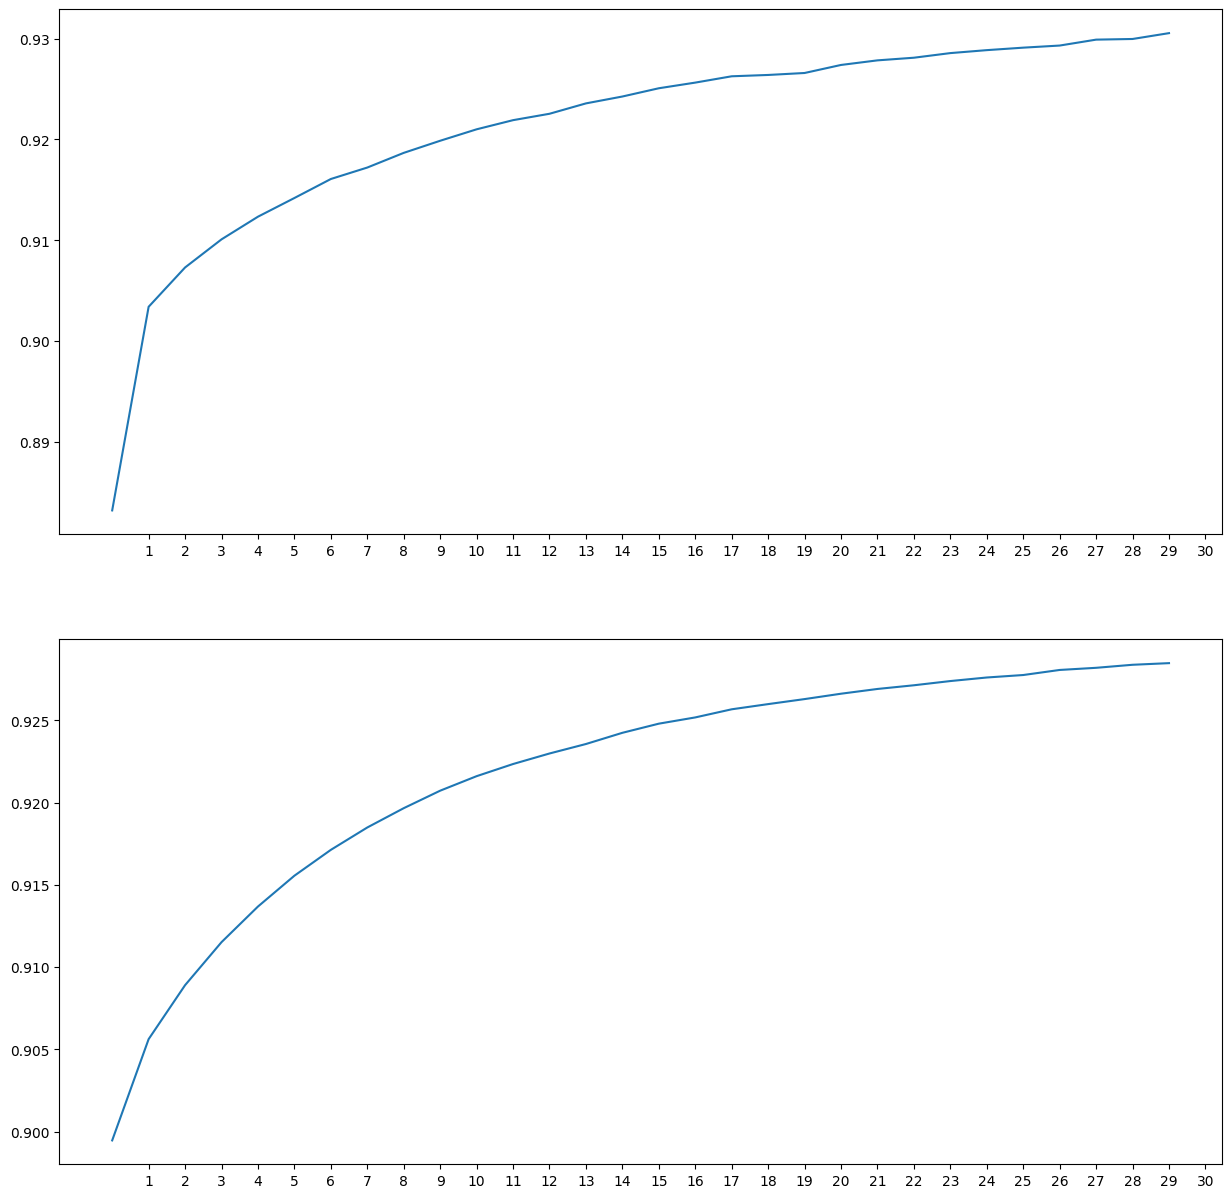

In [227]:
figure, axis = plt.subplots(2, 1, figsize=(15, 15))
axis[0].plot(history[idx]["train_auc"])
axis[0].set_xticks(range(1, len(history[idx]["train_auc"])+1))

axis[1].plot(history[idx]["val_auc"])
axis[1].set_xticks(range(1, len(history[idx]["val_auc"])+1))

plt.show()

Experiment 5
-------------

In [91]:
configs = []

lrs = [0.01, 0.05, 0.1]
decays = [0.1, 0.01, 0.001]

for lr in lrs:
    for decay in decays:
        configs.append({
            "num_epochs": 50,
            "lr": lr,
            "hidden_size": 128,
            "batch_size": 64,
            "num_blocks": 3,
            "p": 0.1,
            "decay": decay
        })

In [92]:
history = []
metrics = []

for config in configs:
    model = LoanModelExtraWithDropout(config["hidden_size"], config["num_blocks"], config["p"])
    
    history_tmp = train(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    config=config
    )
    history.append((history_tmp, config["lr"], config["decay"]))

    model.load_state_dict(torch.load("/kaggle/working/model.pt"))
    
    loss, auc = test(
        model=model,
        test_dataset=test_dataset,
        config=config)

    metrics.append((loss, auc))

100%|██████████| 50/50 [08:08<00:00,  9.76s/it]
<ipython-input-92-3f6158702f0d>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/w

In [93]:
min_value = float("inf")
p = -1
decay = -1
lr = - 1
epoch = -1
idx = -1

for i, losses in enumerate(history):
    min_val_loss = min(losses[0]["val_losses"])

    print(min_val_loss, losses[2], losses[1], metrics[i])
    if min_val_loss < min_value:
        min_value = min_val_loss
        epoch = losses[0]["val_losses"].index(min_val_loss)
        decay = losses[2]
        lr = losses[1]
        idx = i
        
min_value, epoch, decay, lr

0.25984475016593933 0.1 0.01 (0.3012138307094574, 0.8882794380187988)
0.22307544946670532 0.01 0.01 (0.21264219284057617, 0.9214138388633728)
0.18609626591205597 0.001 0.01 (0.1793275773525238, 0.9325467348098755)
0.30321362614631653 0.1 0.05 (0.2999110519886017, 0.886883556842804)
0.2157610058784485 0.01 0.05 (0.20689783990383148, 0.9218276143074036)
0.185512974858284 0.001 0.05 (0.17886991798877716, 0.9330983757972717)
0.3048934042453766 0.1 0.1 (0.29938173294067383, 0.8859615325927734)
0.21857501566410065 0.01 0.1 (0.2096109837293625, 0.9209078550338745)
0.18654438853263855 0.001 0.1 (0.18235456943511963, 0.9323438405990601)


(0.185512974858284, 27, 0.001, 0.05)

TypeError: tuple indices must be integers or slices, not str

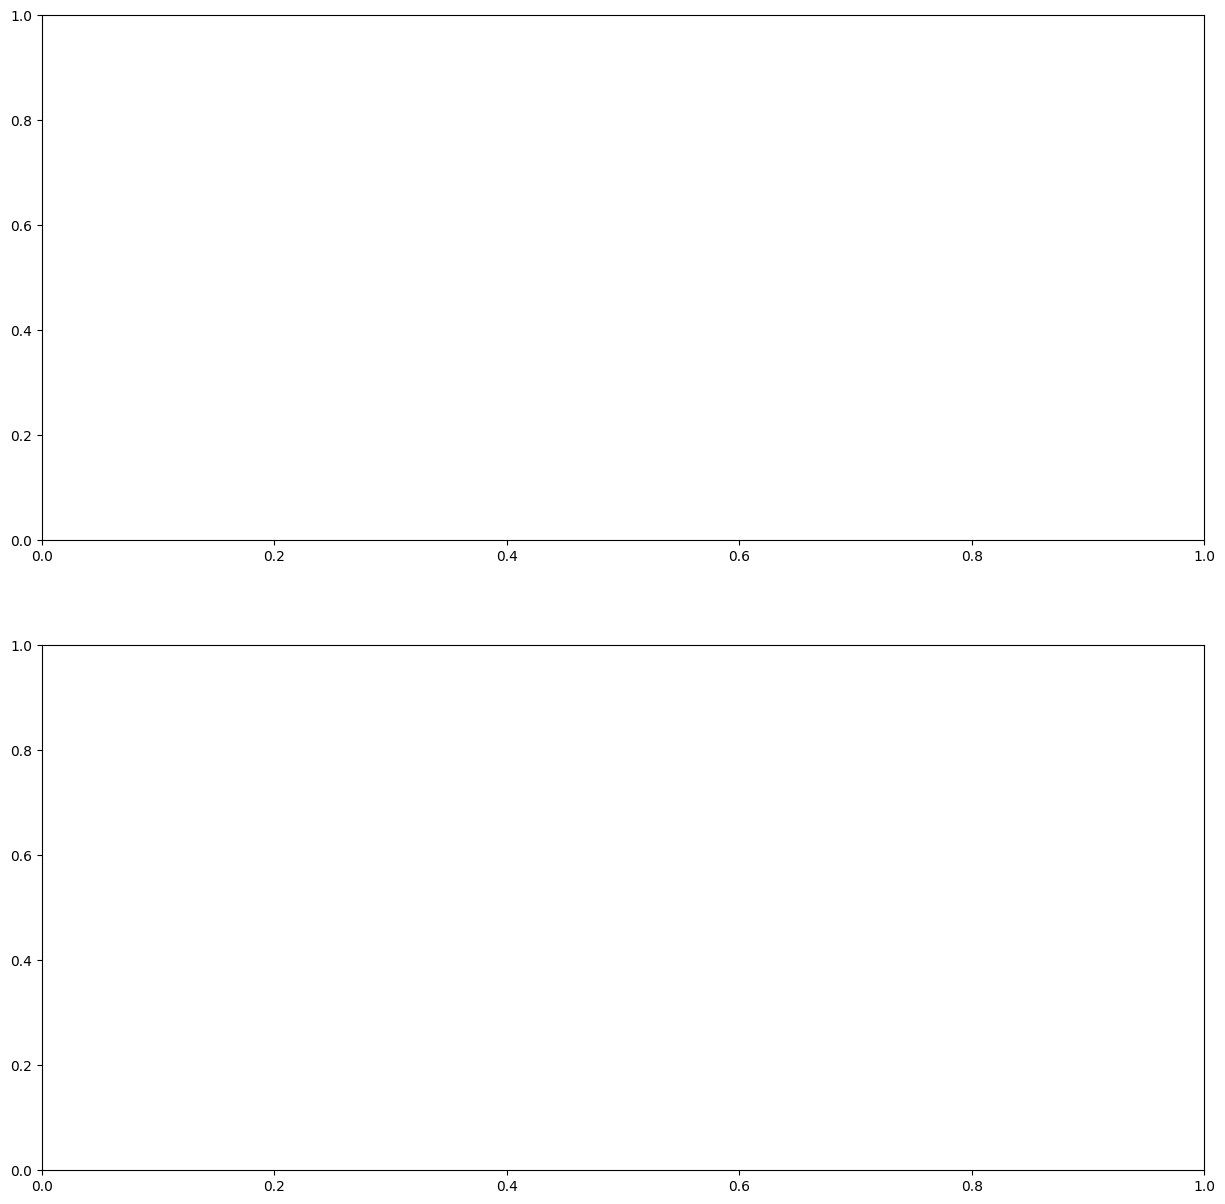

In [94]:
figure, axis = plt.subplots(2, 1, figsize=(15, 15))
axis[0].plot(history[idx]["train_losses"])
axis[0].set_xticks(range(1, len(history[idx]["train_losses"])+1))

axis[1].plot(history[idx]["val_losses"])
axis[1].set_xticks(range(1, len(history[idx]["val_losses"])+1))

plt.show()

In [ ]:
figure, axis = plt.subplots(2, 1, figsize=(15, 15))
axis[0].plot(history[idx]["train_auc"])
axis[0].set_xticks(range(1, len(history[idx]["train_auc"])+1))

axis[1].plot(history[idx]["val_auc"])
axis[1].set_xticks(range(1, len(history[idx]["val_auc"])+1))

plt.show()